In [1]:
from mesmerize_core import *
import numpy as np
from copy import deepcopy
import pandas as pd

2023-01-08 01:22:41.815989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:22:41.899785: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:22:42.272444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2023-01-08 01:22:42.272496: W tensorflow/stream_executor/platform/default/dso_

**You will need `fastplotlib` installed for the visualizations**

In [2]:
from fastplotlib import ImageWidget
from ipywidgets import VBox, IntSlider, Layout

In [3]:
pd.options.display.max_colwidth = 120

# Paths
These are the only variables you will need to modify in this demo notebook. You will need to set the paths according to your own `caiman_data` dir path

Explanation:

`set_parent_raw_data_path()` - This function from `mesmerize_core` sets the **top level raw data directory**. It is generally the top level directory for your raw experimental data. This allows you to move your experiment directory structure between computers, as long as you keep everything under the parent path the same.

For example,

On Linux based systems if you have your experimental data in the following dir:

`/data/my_name/exp_top_level/....`

You could set `/data/my_name` as the "parent raw data path", and you can then move `exp_top_level/...` between computers.

On windows:

`D:/my_name/exp_top_level/...`

You could set `D:/my_name` as the parent raw data path, and you can then move `exp_top_level/...` between computers.

In [4]:
# for this demo set this dir as the path to your `caiman_data` dir
set_parent_raw_data_path("/home/kushalk/caiman_data/")

PosixPath('/home/kushalk/caiman_data')

### Batch path, this is where caiman outputs will be organized

This can be anywhere, it does not need to be under the parent raw data path.

**We recommend using [pathlib](https://docs.python.org/3/library/pathlib.html) instead of manually managing paths as strings. `pathlib` is just a part of the Python standard library, it makes it much easier to deal with paths and saves a lot of time in the long-run! It also makes your paths compatible across operating systems.**

In [5]:
batch_path = get_parent_raw_data_path().joinpath("mesmerize-core-batch/batch.pickle")

# Create a new batch

This creates a new pandas `DataFrame` with the columns that are necessary for mesmerize. In mesmerize we call this the **batch DataFrame**. You can add additional columns relevant to your experiment, but do not modify columns used by mesmerize.

Note that when you create a DataFrame you will need to use `load_batch()` to load it later. You cannot use `create_batch()` to overwrite an existing batch DataFrame

In [6]:
# create a new batch
df = create_batch(batch_path)
# to load existing batches use `load_batch()`
# df = load_batch(batch_path)

# View the dataframe

It is empty with the appropriate columns for mesmerize

In [7]:
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid


# Path to the input movie

An input movie must be anywhere within `raw data path` or `batch path`. We will use the Sue 2p example.

In [8]:
movie_path = get_parent_raw_data_path().joinpath("example_movies/Sue_2x_3000_40_-46.tif")

# Motion correction parameters

Parameters for all algos have the following structure:

```python
{"main": {... params directly passed to caiman}}
```

In [9]:
# We will start with one version of parameters
mcorr_params1 =\
{
  'main': # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'max_shifts': [24, 24],
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# Add a "batch item", this is the combination of:
* algorithm to run, `algo`
* input movie to run the algorithm on, `input_movie_path`
* parameters for the specified algorithm, `params`
* a name for you to keep track of things, usually the same as the movie filename, `item_name`

In [10]:
# add an item to the batch
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=movie_path,
    params=mcorr_params1,
    item_name=movie_path.stem,  # filename of the movie, but can be anything
)

df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",None,None,12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b


## We can now see that there is one item, a.k.a. row or pandas `Series`, in the batch dataframe, we can add another item with the same input movie but with different parameters.

### **When adding batch items with the same `input_movie_path` (i.e. same input movie but different parameters) it is useful to give them the same `item_name`.**

In [11]:
# We create another set of params, useful for gridsearches for example
mcorr_params2 =\
{
  'main':
    {
        'max_shifts': [24, 24],
        'strides': [24, 24],
        'overlaps': [12, 12],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# add other param variant to the batch
df.caiman.add_item(
  algo='mcorr',
  item_name=movie_path.stem,
  input_movie_path=movie_path,
  params=mcorr_params2
)

df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",None,None,12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b
1,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,642df48c-ae0a-4112-9ec0-3a990cfa42ff


## We can see that there are two batch items for the same input movie.

### We can also use a `for` loop to add multiple different parameter variants more efficiently.

In [12]:
# copy the mcorr_params2 dict to make some changes
new_params = deepcopy(mcorr_params2)

# some variants of max_shifts
for shifts in [1, 6, 12]: 
    # deep copy is the safest way to copy dicts
    new_params = deepcopy(new_params)
    
    # assign the "max_shifts"
    new_params["main"]["max_shifts"] = (shifts, shifts)
    
    df.caiman.add_item(
      algo='mcorr',
      item_name=movie_path.stem,
      input_movie_path=movie_path,
      params=new_params
    )

In [13]:
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",None,None,12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b
1,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,642df48c-ae0a-4112-9ec0-3a990cfa42ff
2,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (1, 1), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",None,None,d0f9ec15-e262-457b-94d6-899b915370c3
3,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",None,None,09610b86-917a-41e7-a493-2d036bf44428
4,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (12, 12), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,956ed968-61a8-48e0-ba98-e5f51db09f54


## Now we can see that there are many parameter variants, but it is not easy to see the differences in parameters between the rows that have the same `item_name`.

### We can use the `caiman.get_params_diffs()` extension to see the unique parameters between rows with the same `item_name`

In [14]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

/tmp/ipykernel_286260/1437176290.py:1: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_params_diffs
This feature is new and the might improve in the future

  diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])


0    {'overlaps': (24, 24), 'max_shifts': (24, 24), 'strides': (48, 48)}
1    {'overlaps': (12, 12), 'max_shifts': (24, 24), 'strides': (24, 24)}
2      {'overlaps': (12, 12), 'max_shifts': (1, 1), 'strides': (24, 24)}
3      {'overlaps': (12, 12), 'max_shifts': (6, 6), 'strides': (24, 24)}
4    {'overlaps': (12, 12), 'max_shifts': (12, 12), 'strides': (24, 24)}
Name: params, dtype: object

# Indexing rows and running batch item(s)
#### You can run a single batch item by calling `caiman.run()` on a `Series` (row) of the DataFrame. One way to get the row is integer indexing using `df.iloc[index]`

In [15]:
# get the first batch item
row = df.iloc[0]

### You can see how the various `pandas.Series` extensions are accessible at the level of dataframe rows.

Move the cursor to the end of the following line and press `Tab` on your keyboard. You can select the `caiman.run()` function and press `Shift + Tab` to see the docstring. You can also instead refer to the API docs. https://mesmerize-core.readthedocs.io/en/latest/api/common.html#mesmerize_core.CaimanSeriesExtensions

Note tab completion doesn't work if you use `df.iloc[i].caiman.<method_name>`, you need to apply the indexer to see the docstring.

In [ ]:
row.caiman.

# Run a single batch item

Run the row that we have selected above, on Linux & Mac it will run in subprocess but on Windows it will run in the local kernel. If using the subprocess backend you can use `run(wait=False)` to not block the current kernel when running.

In [16]:
# run the first "batch item"
# this will run in a subprocess by default on Linux & Mac
# on windows it will run locally
process = row.caiman.run()

# reload dataframe from disk when done
df = df.caiman.reload_from_disk()

2023-01-08 01:24:22.492454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:24:22.577603: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:24:22.945769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

starting mc


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
mc finished successfully!
computing projections
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Computing correlation image
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b

# Use a loop to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [17]:
for i, row in df.iterrows():
    if not i > 0: # skip the first item since we've run it already
        continue
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

2023-01-08 01:24:39.207797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:24:39.288556: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:24:39.651759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

starting mc


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/642df48c-ae0a-4112-9ec0-3a990cfa42ff/642df48c-ae0a-4112-9ec0-3a990cfa42ff-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/642df48c-ae0a-4112-9ec0-3a990cfa42ff/642df48c-ae0a-4112-9ec0-3a990cfa42ff-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/642df48c-ae0a-4112-9ec0-3a990cfa42ff/642df48c-ae0a-4112-9ec0-3a990cfa42ff-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
mc finished successfully!
computing projections
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/642df48c-ae0a-4112-9ec0-3a990cfa42ff/642df48c-ae0a-4112-9ec0-3a990cfa42ff-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Computing correlation image
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/642df48c-ae0a-41

2023-01-08 01:24:50.660283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:24:50.742303: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:24:51.107108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

starting mc


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/d0f9ec15-e262-457b-94d6-899b915370c3/d0f9ec15-e262-457b-94d6-899b915370c3-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/d0f9ec15-e262-457b-94d6-899b915370c3/d0f9ec15-e262-457b-94d6-899b915370c3-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
mc finished successfully!
computing projections
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/d0f9ec15-e262-457b-94d6-899b915370c3/d0f9ec15-e262-457b-94d6-899b915370c3-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Computing correlation image
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/d0f9ec15-e262-457b-94d6-899b915370c3/d0f9ec15-e262-457b-94d6-899b915370c3-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
finished computing correlation image


2023-01-08 01:25:02.284607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:25:02.368732: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:25:02.737944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

starting mc


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
mc finished successfully!
computing projections
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Computing correlation image
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
finished computing correlation image


2023-01-08 01:25:13.920242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:25:14.003551: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:25:14.370126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

starting mc


100%|██████████| 1/1 [00:00<00:00, 12.34it/s]

100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/956ed968-61a8-48e0-ba98-e5f51db09f54/956ed968-61a8-48e0-ba98-e5f51db09f54-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/956ed968-61a8-48e0-ba98-e5f51db09f54/956ed968-61a8-48e0-ba98-e5f51db09f54-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/956ed968-61a8-48e0-ba98-e5f51db09f54/956ed968-61a8-48e0-ba98-e5f51db09f54-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
mc finished successfully!
computing projections
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/956ed968-61a8-48e0-ba98-e5f51db09f54/956ed968-61a8-48e0-ba98-e5f51db09f54-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Computing correlation image
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/956ed968-61a8-48

# Reload the DataFrame to see the outputs information for the mcorr batch item
### It is necessary to ALWAYS use `df = df.caiman.reload_from_disk()` after running a single batch item or a loop of batch items. You must not add new batch items until you reload it if you have ran items!

In [18]:
df = df.caiman.reload_from_disk()

## We can see that the `outputs` column has been filled in

In [19]:
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b_mean_projection.n...,None,12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b
1,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 642df48c-ae0a-4112-9ec0-3a990cfa42ff/642df48c-ae0a-4112-9ec0-3a990cfa42ff_mean_projection.n...,None,642df48c-ae0a-4112-9ec0-3a990cfa42ff
2,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (1, 1), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': d0f9ec15-e262-457b-94d6-899b915370c3/d0f9ec15-e262-457b-94d6-899b915370c3_mean_projection.n...,None,d0f9ec15-e262-457b-94d6-899b915370c3
3,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': 09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428_mean_projection.n...,None,09610b86-917a-41e7-a493-2d036bf44428
4,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (12, 12), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 956ed968-61a8-48e0-ba98-e5f51db09f54/956ed968-61a8-48e0-ba98-e5f51db09f54_mean_projection.n...,None,956ed968-61a8-48e0-ba98-e5f51db09f54


# Check if the algorithm ran successfully for a item

In [20]:
# True if the algo ran succesfully
df.iloc[0]["outputs"]["success"]

True

# Visualization using `fastplotlib`
You will need `fastplotlib` installed for this, see https://github.com/kushalkolar/fastplotlib

# Get the input movie and mcorr so we can visualize them

Note that you DO NOT need to manually work with file paths. For tiff input files it returns it as a memmaped array (if possible) with lazy loading. It will try to use a mesmerize `LazyArray` if the file cannot be memmaped.

In [21]:
# you can change the index to look at the mcorr results of different batch items
index = 0

# get input movie as memmap
input_movie = df.iloc[index].caiman.get_input_movie()

# load mcorr output movie, also as a memmaped array
mcorr_movie = df.iloc[index].mcorr.get_output()

Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap


# Visualize raw & MCorr movie side-by-side

### fastplotlib `ImageWidget` to visualize raw & mcorr movie side by side

`ImageWidget` assumes `"txy"` dimension order by default for 2D movies. You can set other orders using the `dims_order` kwarg

In [22]:
mcorr_iw = ImageWidget(
    data=[input_movie, mcorr_movie], 
    vmin_vmax_sliders=True, 
    cmap="gnuplot2"
)
mcorr_iw.show()

RFBOutputContext()

# Frame averaging over a window

This makes it easier to visually inspect motion

In [23]:
# window function on the "t" (time) dimension, using mean of 17 frames
mcorr_iw.window_funcs = {"t": (np.mean, 17)}

## Close the canvas to free up GPU processing time, not necessary if you have a powerful GPU

In [24]:
mcorr_iw.plot.canvas.close()

## With `ImageWidget` you can view all 5 mcorr results simultaneously!

### This depends on your hard drive's capabilities

In [25]:
# first item is just the raw movie
movies = [df.iloc[0].caiman.get_input_movie()]

# subplot titles
subplot_names = ["raw"]

# we will use the mean images later
means = [df.iloc[0].caiman.get_projection("mean")]

# add all the mcorr outputs to the list
for i, row in df.iterrows():
    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())
    
    # the unique params for this item
    params = diffs.iloc[i]
    
    # subplot title to show dataframe index
    subplot_names.append(f"ix: {i}")
    
    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))

# create the widget
mcorr_iw_multiple = ImageWidget(
    data=movies,  # list of movies
    window_funcs={"t": (np.mean, 17)}, # window_funcs is also a kwarg
    vmin_vmax_sliders=True,
    names=subplot_names,  # subplot names used for titles
    cmap="gnuplot2"
)
mcorr_iw_multiple.show()

Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b/12aeb4bb-e3d2-4b31-b2e6-8a52e200e88b-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/642df48c-ae0a-4112-9ec0-3a990cfa42ff/642df48c-ae0a-4112-9ec0-3a990cfa42ff-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/d0f9ec15-e262-457b-94d6-899b915370c3/d0f9ec15-e262-457b-94d6-899b915370c3-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/956ed968-61a8-48e0-ba98-e5f51db09f54/956ed968-61a8-48e0-ba98-e5f51db09f54-Sue_2x_3000_40_-46

RFBOutputContext()

In [26]:
df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])

/tmp/ipykernel_286260/3787477196.py:1: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_params_diffs
This feature is new and the might improve in the future

  df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])


0    {'overlaps': (24, 24), 'max_shifts': (24, 24), 'strides': (48, 48)}
1    {'overlaps': (12, 12), 'max_shifts': (24, 24), 'strides': (24, 24)}
2      {'overlaps': (12, 12), 'max_shifts': (1, 1), 'strides': (24, 24)}
3      {'overlaps': (12, 12), 'max_shifts': (6, 6), 'strides': (24, 24)}
4    {'overlaps': (12, 12), 'max_shifts': (12, 12), 'strides': (24, 24)}
Name: params, dtype: object

### Modify the `window_funcs` at any time

In [27]:
mcorr_iw_multiple.window_funcs["t"].window_size = 7

## There is some motion on the left side of of `ix: 2` at timepoint `1452`, `2037` and a few others. This will be more obvious if we substract a mean image from each frame. You can use `frame_apply` to apply a function before displaying frames in the `ImageWidget`

This can be combined with `window_funcs` or used by itself. If used in combination with `window_funcs`, the window functions are computed first and then fed to `frame_apply`.

For this example the `frame_apply` functions subtract the mean image for each movie.

General form:

```python
{
    data_ix: function() # returns 2D frame
    ...
}
```

In [28]:
subtract_means = {
    0: lambda x: x - means[0],
    1: lambda x: x - means[1],
    2: lambda x: x - means[2],
    3: lambda x: x - means[3],
    4: lambda x: x - means[4],
    5: lambda x: x - means[5]
}

In [29]:
mcorr_iw_multiple.frame_apply = subtract_means

### Different colormaps can make the motion more obvious

In [30]:
for sp in mcorr_iw_multiple.plot:
    sp.get_graphics()[0].cmap = "jet"

In [31]:
# disable frame apply
mcorr_iw_multiple.frame_apply = dict()

# ix `3` seems to work the best so we will cleanup the DataFrame and remove all other items.

### You can remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`

**Note that this also cleans up the output data in the batch directory!**

In [32]:
# make a list of rows we want to keep using the uuids
rows_keep = [df.iloc[3].uuid]
rows_keep

['09610b86-917a-41e7-a493-2d036bf44428']

In [33]:
for i, row in df.iterrows():
    if row.uuid not in rows_keep:
        df.caiman.remove_item(row.uuid)

df

/home/kushalk/repos/mesmerize-core/mesmerize_core/caiman_extensions/common.py:206: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_children
This feature will change in the future and directly return the  a DataFrame of children (rows, ie. child batch items row) instead of a list of UUIDs

  children = self.get_children(index)
/home/kushalk/repos/mesmerize-core/mesmerize_core/caiman_extensions/common.py:206: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_children
This feature will change in the future and directly return the  a DataFrame of children (rows, ie. child batch items row) instead of a list of UUIDs

  children = self.get_children(index)
/home/kushalk/repos/mesmerize-core/mesmerize_core/caiman_extensions/common.py:206: FutureWarning: You are trying to use the following experi

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': 09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428_mean_projection.n...,None,09610b86-917a-41e7-a493-2d036bf44428


### As you can see above, the numerical index changed for what was previously item 3. Indices are always reset when you use `caiman.remove_item()`. However, UUIDs are always maintained.

# CNMF

## Continue from mcorr above and perform CNMF using the good mcorr output.

First, the params for CNMF. Put the CNMF params within the `main` key, `refit` is if you want to run CNMF for a second iteration.

In [36]:
# some params for CNMF
params_cnmf =\
{
    'main': # indicates that these are the "main" params for the CNMF algo
        {
            'fr': 30, # framerate, very important!
            'p': 1,
            'nb': 2,
            'merge_thr': 0.85,
            'rf': 15,
            'stride': 6, # "stride" for cnmf, "strides" for mcorr
            'K': 4,
            'gSig': [4, 4],
            'ssub': 1,
            'tsub': 1,
            'method_init': 'greedy_roi',
            'min_SNR': 2.0,
            'rval_thr': 0.7,
            'use_cnn': True,
            'min_cnn_thr': 0.8,
            'cnn_lowest': 0.1,
            'decay_time': 0.4,
        },
    'refit': True, # If `True`, run a second iteration of CNMF
}

### Add a single cnmf item to the batch

In [35]:
# add a batch item
df.caiman.add_item(
    algo='cnmf', # algo is cnmf
    input_movie_path=df.iloc[0],  # use mcorr output from a completed batch item
    params=params_cnmf,
    item_name=df.iloc[0]["item_name"], # use the same item name
)

### Just like with motion correction, we can use loops to add multiple parameter variants. This is useful to perform a parameter search to find the params that work best for your dataset. Here I will use `itertools.product` which is better than deeply nested loops.

In [37]:
from itertools import product

# variants of several parameters
gSig_variants = [6, 8]
K_variants = [4, 8]
merge_thr_variants = [0.8, 0.95]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmf)

# create a parameter grid
parameter_grid = product(gSig_variants, K_variants, merge_thr_variants)

# a single for loop to go through all the various parameter combinations
for gSig, K, merge_thr in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)
    
    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr
    
    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmf",
        item_name=df.iloc[0]["item_name"],
        input_movie_path=df.iloc[0],
        params=new_params_cnmf
    )

### See that there are a lot of new cnmf batch items

In [38]:
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,Sue_2x_3000_40_-46,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': 09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428_mean_projection.n...,None,09610b86-917a-41e7-a493-2d036bf44428
1,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 't...",None,None,2b9dabd8-7d22-4327-8479-aea36bde79cf
2,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'ts...",None,None,38f85afb-417f-453a-8da5-28753b0dc290
3,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 't...",None,None,a49689ad-f093-49ff-9a86-058835eccd34
4,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'ts...",None,None,f67dbcb9-fd5b-4d81-acc4-f080a7f81db4
5,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 't...",None,None,ff76c624-2c29-4c2d-ba91-3eb471a8e9e3
6,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'ts...",None,None,879d1d8b-dfe7-4b4f-aa2f-b987d83f7788
7,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 't...",None,None,539745c5-ec3e-4a63-a7c2-eb41af9a080e
8,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'ts...",None,None,da760704-f760-4f34-b26a-06eb5cc3cfec
9,cnmf,Sue_2x_3000_40_-46,09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 't...",None,None,f4474d42-f6ae-4fba-a1a5-c181b4b1796e


## Since it is difficult to see the different parameter variants above, we can just view the diffs

### The index numbers on the diffs correspond to the indices in the parent DataFrame above

In [39]:
df.caiman.get_params_diffs(algo="cnmf", item_name=df.iloc[1]["item_name"])

/tmp/ipykernel_286260/3330105589.py:1: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_params_diffs
This feature is new and the might improve in the future

  df.caiman.get_params_diffs(algo="cnmf", item_name=df.iloc[1]["item_name"])


1    {'K': 4, 'gSig': (4, 4), 'merge_thr': 0.85}
2     {'K': 4, 'gSig': (6, 6), 'merge_thr': 0.8}
3    {'K': 4, 'gSig': (6, 6), 'merge_thr': 0.95}
4     {'K': 8, 'gSig': (6, 6), 'merge_thr': 0.8}
5    {'K': 8, 'gSig': (6, 6), 'merge_thr': 0.95}
6     {'K': 4, 'gSig': (8, 8), 'merge_thr': 0.8}
7    {'K': 4, 'gSig': (8, 8), 'merge_thr': 0.95}
8     {'K': 8, 'gSig': (8, 8), 'merge_thr': 0.8}
9    {'K': 8, 'gSig': (8, 8), 'merge_thr': 0.95}
Name: params, dtype: object

### Run the added `cnmf` batch items, they start at index 1 as we can see from the DataFrame.

In [40]:
for i, row in df.iterrows():
    if i < 1:
        continue
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = load_batch(df.paths.get_batch_path())

2023-01-08 01:31:09.620801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:31:09.704789: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:31:10.078529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             2b9dabd8-7d22-4327-8479-aea36bde79cf
Name: 1, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf4442

2023-01-08 01:31:22.359823: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:31:22.359852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:31:22.359858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:31:22.360004: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:31:22.360026: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:31:22.360033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:31:22.360250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
5/5 [==============================] - 0s 11ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/2b9dabd8-7d22-4327-8479-aea36bde79cf_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/2b9dabd8-7d22-4327-8479-aea36bde79cf_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/2b9dabd8-7d22-4327-8479-aea36bde79cf_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/2b9dabd8-7d22-4327-8479-aea36bde79cf_cnmf-memmap_d1_170_d2_170_d3_1_order_C

2023-01-08 01:31:25.956403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:31:26.039455: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:31:26.410378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             38f85afb-417f-453a-8da5-28753b0dc290
Name: 2, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428

2023-01-08 01:31:39.903212: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:31:39.903246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:31:39.903254: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:31:39.903392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:31:39.903425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:31:39.903433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:31:39.903648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 11ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/38f85afb-417f-453a-8da5-28753b0dc290_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/38f85afb-417f-453a-8da5-28753b0dc290_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/38f85afb-417f-453a-8da5-28753b0dc290_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/38f85afb-417f-453a-8da5-28753b0dc290_cnmf-memmap_d1_170_d2_170_d3_1_order_C

2023-01-08 01:31:43.497785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:31:43.582669: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:31:43.957665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             a49689ad-f093-49ff-9a86-058835eccd34
Name: 3, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf4442

2023-01-08 01:31:57.690996: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:31:57.691027: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:31:57.691032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:31:57.691168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:31:57.691187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:31:57.691191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:31:57.691422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 11ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/a49689ad-f093-49ff-9a86-058835eccd34_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/a49689ad-f093-49ff-9a86-058835eccd34_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/a49689ad-f093-49ff-9a86-058835eccd34_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/a49689ad-f093-49ff-9a86-058835eccd34_cnmf-memmap_d1_170_d2_170_d3_1_order_C

2023-01-08 01:32:01.493521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:32:01.577443: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:32:01.950236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             f67dbcb9-fd5b-4d81-acc4-f080a7f81db4
Name: 4, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428

2023-01-08 01:32:18.253282: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:32:18.253303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:32:18.253306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:32:18.253403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:32:18.253416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:32:18.253419: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:32:18.253571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
11/11 [==============================] - 0s 10ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f67dbcb9-fd5b-4d81-acc4-f080a7f81db4_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f67dbcb9-fd5b-4d81-acc4-f080a7f81db4_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f67dbcb9-fd5b-4d81-acc4-f080a7f81db4_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f67dbcb9-fd5b-4d81-acc4-f080a7f81db4_cnmf-memmap_d1_170_d2_170_d3_1_order

2023-01-08 01:32:21.996558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:32:22.079519: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:32:22.452268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             ff76c624-2c29-4c2d-ba91-3eb471a8e9e3
Name: 5, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf4442

2023-01-08 01:32:39.381456: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:32:39.381479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:32:39.381483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:32:39.381584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:32:39.381598: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:32:39.381601: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:32:39.381751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
12/12 [==============================] - 0s 10ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/ff76c624-2c29-4c2d-ba91-3eb471a8e9e3_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/ff76c624-2c29-4c2d-ba91-3eb471a8e9e3_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/ff76c624-2c29-4c2d-ba91-3eb471a8e9e3_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/ff76c624-2c29-4c2d-ba91-3eb471a8e9e3_cnmf-memmap_d1_170_d2_170_d3_1_order

2023-01-08 01:32:43.116534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:32:43.199247: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:32:43.572060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             879d1d8b-dfe7-4b4f-aa2f-b987d83f7788
Name: 6, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
making memmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/879d1d8b-dfe7-4b4f-aa2f-b987d83f7788_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap


2023-01-08 01:32:58.389478: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:32:58.389498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:32:58.389501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:32:58.389603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:32:58.389615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:32:58.389619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:32:58.389791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 9ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/879d1d8b-dfe7-4b4f-aa2f-b987d83f7788_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/879d1d8b-dfe7-4b4f-aa2f-b987d83f7788_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/879d1d8b-dfe7-4b4f-aa2f-b987d83f7788_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/879d1d8b-dfe7-4b4f-aa2f-b987d83f7788_cnmf-memmap_d1_170_d2_170_d3_1_order_C_

2023-01-08 01:33:02.142924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:33:02.233379: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:33:02.608255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             539745c5-ec3e-4a63-a7c2-eb41af9a080e
Name: 7, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
making memmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/539745c5-ec3e-4a63-a7c2-eb41af9a080e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap


2023-01-08 01:33:17.433498: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:33:17.433522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:33:17.433525: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:33:17.433637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:33:17.433651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:33:17.433654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:33:17.433816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 11ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/539745c5-ec3e-4a63-a7c2-eb41af9a080e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/539745c5-ec3e-4a63-a7c2-eb41af9a080e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/539745c5-ec3e-4a63-a7c2-eb41af9a080e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/539745c5-ec3e-4a63-a7c2-eb41af9a080e_cnmf-memmap_d1_170_d2_170_d3_1_order_C

2023-01-08 01:33:20.979488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:33:21.061581: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:33:21.426480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             da760704-f760-4f34-b26a-06eb5cc3cfec
Name: 8, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
making memmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/da760704-f760-4f34-b26a-06eb5cc3cfec_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap


2023-01-08 01:33:39.939145: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:33:39.939174: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:33:39.939179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:33:39.939313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:33:39.939331: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:33:39.939337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:33:39.939553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
12/12 [==============================] - 0s 10ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/da760704-f760-4f34-b26a-06eb5cc3cfec_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/da760704-f760-4f34-b26a-06eb5cc3cfec_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/da760704-f760-4f34-b26a-06eb5cc3cfec_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/da760704-f760-4f34-b26a-06eb5cc3cfec_cnmf-memmap_d1_170_d2_170_d3_1_order

2023-01-08 01:33:43.710247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 01:33:43.791697: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-08 01:33:44.162603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/home/kushalk/python-venvs/mescore/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib6

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                          Sue_2x_3000_40_-46
input_movie_path    09610b86-917a-41e7-a493-2d036bf44428/09610b86-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
comments                                                         None
uuid                             f4474d42-f6ae-4fba-a1a5-c181b4b1796e
Name: 9, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/09610b86-917a-41e7-a493-2d036bf44428-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap
making memmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f4474d42-f6ae-4fba-a1a5-c181b4b1796e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap


2023-01-08 01:34:02.991238: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-08 01:34:02.991270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hantman-calcium
2023-01-08 01:34:02.991276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hantman-calcium
2023-01-08 01:34:02.991406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-01-08 01:34:02.991425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-01-08 01:34:02.991430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-01-08 01:34:02.991645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU

performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/kushalk/caiman_data/model/cnn_model.json
12/12 [==============================] - 0s 10ms/step
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f4474d42-f6ae-4fba-a1a5-c181b4b1796e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f4474d42-f6ae-4fba-a1a5-c181b4b1796e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f4474d42-f6ae-4fba-a1a5-c181b4b1796e_cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000.mmap
Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/09610b86-917a-41e7-a493-2d036bf44428/f4474d42-f6ae-4fba-a1a5-c181b4b1796e_cnmf-memmap_d1_170_d2_170_d3_1_order

### We now have CNMF outputs

In [135]:
df = df.caiman.reload_from_disk()
df[df["algo"] == "cnmf"]

,algo,item_name,input_movie_path,params,outputs,comments,uuid
1,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 't...",{'mean-projection-path': aa43b012-7352-4f6d-906d-43df7d91972e/aa43b012-7352-4f6d-906d-43df7d91972e_mean_projection.n...,None,aa43b012-7352-4f6d-906d-43df7d91972e
2,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'ts...",{'mean-projection-path': 858ae543-70db-48df-975c-9a4d98847234/858ae543-70db-48df-975c-9a4d98847234_mean_projection.n...,None,858ae543-70db-48df-975c-9a4d98847234
3,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 't...",{'mean-projection-path': 1f83e8dd-9c9b-4f57-8ee1-6b2e5c9e7afe/1f83e8dd-9c9b-4f57-8ee1-6b2e5c9e7afe_mean_projection.n...,None,1f83e8dd-9c9b-4f57-8ee1-6b2e5c9e7afe
4,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'ts...",{'mean-projection-path': a41bc279-4a98-4f34-8f4e-e19037991fde/a41bc279-4a98-4f34-8f4e-e19037991fde_mean_projection.n...,None,a41bc279-4a98-4f34-8f4e-e19037991fde
5,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 't...",{'mean-projection-path': c39a789d-c233-4b4c-89d1-cab1ba6ba251/c39a789d-c233-4b4c-89d1-cab1ba6ba251_mean_projection.n...,None,c39a789d-c233-4b4c-89d1-cab1ba6ba251
6,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'ts...",{'mean-projection-path': 6619cfdc-b4ac-44fc-9fb2-691eb9a73b14/6619cfdc-b4ac-44fc-9fb2-691eb9a73b14_mean_projection.n...,None,6619cfdc-b4ac-44fc-9fb2-691eb9a73b14
7,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 't...",{'mean-projection-path': ff63724a-052b-44b7-9421-9daea5f7e380/ff63724a-052b-44b7-9421-9daea5f7e380_mean_projection.n...,None,ff63724a-052b-44b7-9421-9daea5f7e380
8,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'ts...",{'mean-projection-path': 96edc395-671c-49b9-8ecf-870a4c4f0c1a/96edc395-671c-49b9-8ecf-870a4c4f0c1a_mean_projection.n...,None,96edc395-671c-49b9-8ecf-870a4c4f0c1a
9,cnmf,Sue_2x_3000_40_-46,abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 't...",{'mean-projection-path': 9992fd2c-3a4f-449a-a404-2b1c4bb0772e/9992fd2c-3a4f-449a-a404-2b1c4bb0772e_mean_projection.n...,None,9992fd2c-3a4f-449a-a404-2b1c4bb0772e


In [136]:
# see which batch items completed succcessfully
df[df["algo"] == "cnmf"]["outputs"].apply(lambda x: x["success"])

1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: outputs, dtype: bool

# Load outputs

CNMF pandas extensions API: https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html 

In [ ]:
# You can change this to plot the outputs for different batch items
index = 1

# get the motion corrected input movie as a memmap
cnmf_movie = df.iloc[index].caiman.get_input_movie()

# we can get the contours of the spatial components
contours, coms = df.iloc[index].cnmf.get_contours("all", swap_dim=False)

# and temporal components
temporal = df.iloc[index].cnmf.get_temporal("all")

ixs_good = df.iloc[index].cnmf.get_good_components()
ixs_bad = df.iloc[index].cnmf.get_bad_components()

Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap


# Visualize CNMF outputs. We'll create some simple and more complex plots.

### `ImageWidget` to view contours, and a simple `fastplotlib.Plot` to view temporal components

In [ ]:
# LineSlider is very new and experimental and is likely to change
# that's why it's not exposed as a top-level import
from fastplotlib.graphics.line_slider import LineSlider

In [ ]:
# for the image data and contours
iw_cnmf = ImageWidget(cnmf_movie, vmin_vmax_sliders=True, cmap="gnuplot2")

# add good contours to the plot within the widget
contours_graphic = iw_cnmf.plot.add_line_collection(contours, colors="cyan", name="contours")
contours_graphic[ixs_good].colors = "cyan"
contours_graphic[ixs_bad].colors = "magenta"


# temporal plot
plot_temporal = Plot()

temporal_graphic = plot_temporal.add_line_collection(temporal, colors="cyan", name="temporal")
temporal_graphic[ixs_good].colors = "cyan"
temporal_graphic[ixs_bad].colors = "magenta"

# a vertical line that is syncronized to the image widget "t" (timepoint) slider
_ls = LineSlider(x_pos=0, bounds=(temporal.min(), temporal.max()), slider=iw_cnmf.sliders["t"])
plot_temporal.add_graphic(_ls)

# stack them
VBox([plot_temporal.show(), iw_cnmf.show()])

RFBOutputContext()

RFBOutputContext()

Auto-scale temporal plot, you can only do this after calling `show()`

In [ ]:
plot_temporal.auto_scale()
plot_temporal.camera.scale.x = 0.85

# Interactivity

In [ ]:
# don't worry about understanding this function
def euclidean(source, target, event, new_data):
    """maps click events to contour"""
    # calculate coms of line collection
    indices = np.array(event.pick_info["index"])
    
    coms = list()

    for contour in target.items:
        coors = contour.data()[~np.isnan(contour.data()).any(axis=1)]
        com = coors.mean(axis=0)
        coms.append(com)

    # euclidean distance to find closest index of com 
    indices = np.append(indices, [0])
    
    ix = int(np.linalg.norm((coms - indices), axis=1).argsort()[0])
    
    target._set_feature(feature="colors", new_data=new_data, indices=ix)
    
    return None

In [ ]:
# so we can view them one by one, first hide all of them
temporal_graphic[:].present = False

image_graphic = iw_cnmf.plot["image"]

# link image to contours
image_graphic.link(
    "click",
    target=contours_graphic,
    feature="colors", 
    new_data="w", 
    callback=euclidean
)

# link contour color changes (which are triggered by the click events as defined above) to everything else

# thickness of contour
contours_graphic.link("colors", target=contours_graphic, feature="thickness", new_data=5)

# toggle temporal component when contour changes color
contours_graphic.link("colors", target=temporal_graphic, feature="present", new_data=True)
# autoscale temporal plot to the current temporal component
temporal_graphic[:].present.add_event_handler(plot_temporal.auto_scale)

/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of 'contours' fastplotlib.LineCollection @ 0x7f38e09e4490> is already registered.
  warn(f"Event handler {handler} is already registered.")


Close canvases if you GPU is slow

In [ ]:
plot_temporal.canvas.close()
iw_cnmf.plot.canvas.close()

# View the reconstructed movie, residuals, and reconstructed background

### We can get each of these as a mesmerize `LazyArray` which allows fast visualization of larger-than-RAM arrays that can be computed on the fly.

In [ ]:
# reconstructed movie, A * C
rcm = df.iloc[index].cnmf.get_rcm()
rcm

LazyArrayRCM @0x7f38e09e60e0
LazyArray for reconstructed movie, i.e. A ⊗ C
Frames are computed only upon indexing
shape [frames, x, y]: (3000, 170, 170)
n_components: 155

### `LazyArray` behaves similar to numpy arrays. But frames are computed only uppon indexing.

In [ ]:
rcm[100]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.37123169,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.4506279 ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Some lazy arrays contain pre-computed min and max for the array, and other useful properties

In [ ]:
rcm.max

1720.0178092400397

RFBOutputContext()


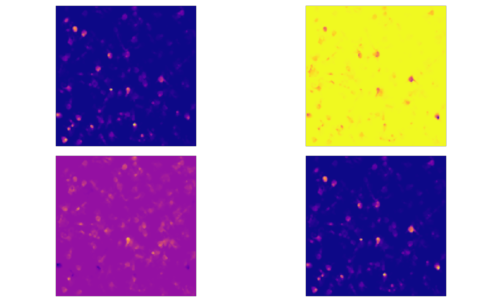

JupyterWgpuCanvas()

In [ ]:
gp = GridPlot((2, 2))

for sp, img in zip(gp, [rcm.max_image, rcm.min_image, rcm.mean_image, rcm.std_image]):
    sp.add_image(img)
    
gp.show()

### Get size of the full array in gigabytes if it were entirely stored in RAM

In [ ]:
rcm.nbytes_gb

0.6936

# Visualize RCM, RCB and Residuals

In [ ]:
rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()

iw_cnmf_grid = ImageWidget(
    data=[cnmf_movie, rcm, rcb, residuals],
    vmin_vmax_sliders=True,
    cmap="gnuplot2",
    names=["movie", "A * C", "b * f", "residuals"]
)

iw_cnmf_grid.show()

Decode mmap filename /home/kushalk/caiman_data/mesmerize-core-batch/abe66fc1-5303-4b43-952b-ccf8ebe82301/abe66fc1-5303-4b43-952b-ccf8ebe82301-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000.mmap


RFBOutputContext()

/home/kushalk/repos/mesmerize-core/mesmerize_core/arrays/_cnmf.py:246: UserWarning: min and max not yet implemented for LazyArrayResiduals. Using first frame of raw movie
  warn("min and max not yet implemented for LazyArrayResiduals. "
/home/kushalk/repos/mesmerize-core/mesmerize_core/arrays/_cnmf.py:252: UserWarning: min and max not yet implemented for LazyArrayResiduals. Using first frame of raw movie
  warn("min and max not yet implemented for LazyArrayResiduals. "


### Close the canvas to free up the GPU if necessary 

In [ ]:
iw_cnmf_grid.plot.canvas.close()

# Visualize movie, rcm, and stack of temporal components

This example shows only good components, but as shown before you can also compare between good and bad components if you want

In [ ]:
# 1 row, 3 columns, sync the first 2 subplots plots
cnmf_grid_more = GridPlot((1, 3), controllers=[[0, 0, 1]], names=[["movie", "rcm", "temporal"]])

# movie and rcm, rcm is a lazy array and behaves similar to numpy arrays
movie_graphic = cnmf_grid_more["movie"].add_image(cnmf_movie[0], cmap="gnuplot2")
rcm_graphic = cnmf_grid_more["rcm"].add_image(rcm[0], cmap="gnuplot2")

# contours for good components
contours_good, coms = df.iloc[index].cnmf.get_contours("good")

# random colors for contours and temporal components
# make an RGBA array for each color
rand_colors = np.random.rand(len(contours_good), 4)  # [n_contours, RGBA]
rand_colors[:, -1] = 1 # set alpha = 1

# get temporal of only good components
temporal_good = df.iloc[index].cnmf.get_temporal("good")

# add contours to both movie and rcm subplots
contours_movie = cnmf_grid_more["movie"].add_line_collection(contours_good, colors=rand_colors)
contours_rcm = cnmf_grid_more["rcm"].add_line_collection(contours_good, colors=rand_colors)

# line stack of temporal components
temporal_stack = cnmf_grid_more["temporal"].add_line_stack(temporal_good, colors=rand_colors)

# plot single temporal, just like before
plot_temporal_single = Plot()
temporal_graphic = plot_temporal_single.add_line_collection(temporal_good, colors=rand_colors)

# since this is a GridPlot and not an ImageWidget we need to define sliders
slider = IntSlider(min=0, max=cnmf_movie.shape[0] - 1, value=0, step=1)

# vertical line sliders
_ls = LineSlider(x_pos=0, bounds=(temporal.min(), temporal.max()), slider=slider)
_ls2 = LineSlider(x_pos=0, bounds=(temporal.min(), temporal.max() + temporal_stack.items[-1].position.y), slider=slider)
plot_temporal_single.add_graphic(_ls)
cnmf_grid_more["temporal"].add_graphic(_ls2)

# function to update each frame
def update_frame(change):
    ix = change["new"]
    movie_graphic.data = cnmf_movie[ix]
    rcm_graphic.data = rcm[ix]
    
slider.observe(update_frame, "value")

@plot_temporal_single.renderer.add_event_handler("resize")
def update_slider_width(*args):
    width, h = plot_temporal_single.renderer.logical_size
    slider.layout = Layout(width=f"{width}px")
    
VBox([plot_temporal_single.show(), cnmf_grid_more.show(), slider])

RFBOutputContext()

RFBOutputContext()

### autoscaling

In [ ]:
plot_temporal_single.auto_scale()
plot_temporal_single.camera.scale.x = 0.85
cnmf_grid_more["temporal"].auto_scale()

### Interactivity just like before

In [ ]:
# so we can view them one by one, first hide all of them
temporal_graphic[:].present = False

# link image to contours
movie_graphic.link(
    "click",
    target=contours_movie,
    feature="colors", 
    new_data="w", 
    callback=euclidean  # we cam re-use it from before
)

# link image to contours
rcm_graphic.link(
    "click",
    target=contours_rcm,
    feature="colors", 
    new_data="w", 
    callback=euclidean  # we cam re-use it from before
)

In [ ]:
# contours colors -> contor thickness
contours_movie.link("colors", target=contours_movie, feature="thickness", new_data=5)
contours_rcm.link("colors", target=contours_rcm, feature="thickness", new_data=5)

In [ ]:
# contours_movie <-> contours_rcm
contours_rcm.link("colors", target=contours_movie, feature="colors", new_data="w", bidirectional=True)

/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineCollection @ 0x7f3817e11210> is already registered.
  warn(f"Event handler {handler} is already registered.")
/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineCollection @ 0x7f3834199690> is already registered.
  warn(f"Event handler {handler} is already registered.")


RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
contours_movie.registered_callbacks

{'colors': [CallbackData(target=fastplotlib.LineCollection @ 0x7f4aa1ec1cf0, feature='thickness', new_data=5, callback_function=None),
  CallbackData(target=fastplotlib.LineCollection @ 0x7f4aa1ec1f30, feature='colors', new_data='w', callback_function=None)]}

In [ ]:
# contours -> temporal stack
contours_movie.link("colors", target=temporal_stack, feature="colors", new_data="w")
contours_movie.link("colors", target=temporal_stack, feature="thickness", new_data=4)

In [ ]:
# contours rcm -> temporal stack
contours_rcm.link("colors", target=temporal_stack, feature="colors", new_data="w")
contours_rcm.link("colors", target=temporal_stack, feature="thickness", new_data=4)

In [ ]:
# temporal stack -> temporal single
temporal_stack.link("colors", target=temporal_graphic, feature="present", new_data=True)
temporal_stack.link("colors", target=temporal_graphic, feature="colors", new_data="w")

# temporal stack click -> contours
# since this changes the contour's color, it will trigger everything else defined above
temporal_stack.link("click", target=temporal_graphic, feature="colors", new_data="w")

# autoscale temporal plot to the current temporal component
temporal_graphic[:].present.add_event_handler(plot_temporal_single.auto_scale)

/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineCollection @ 0x7f4ab3f0bd00> is already registered.
  warn(f"Event handler {handler} is already registered.")
/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineCollection @ 0x7f4ab3f0bf40> is already registered.
  warn(f"Event handler {handler} is already registered.")
/home/kushalk/repos/fastplotlib/fastplotlib/graphics/features/_base.py:87: UserWarning: Event handler <bound method Interaction.event_handler of fastplotlib.LineStack @ 0x7f4ab3f283a0> is already registered.
  warn(f"Event handler {handler} is already registered.")


### You can get the temporal components using `cnmf.get_temporal()`. Visualize using `seaborn`, stacked line plots and heatmaps are not yet implemented in `fastplotlib`.

<AxesSubplot:>

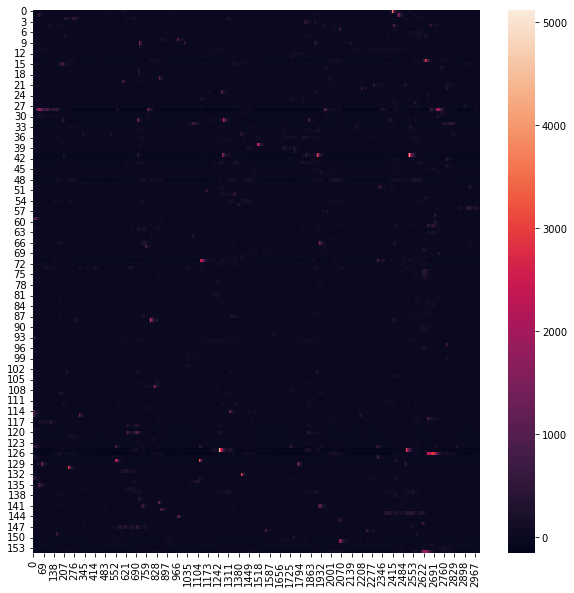

In [ ]:
import seaborn as sns # if you have seaborn installed

fig = plt.figure(figsize=(10, 10))
sns.heatmap(df.iloc[index].cnmf.get_temporal())

# Component Evaluation

These are some ipywidgets that you can use for interactive component evaluation

In [ ]:
# import some stuff
from ipywidgets import FloatSlider, FloatText, Label, HBox, VBox, link, Layout
from collections import OrderedDict

#### This is just GUI layout stuff

In [ ]:
# low thresholds
lt = OrderedDict(
    rval_lowest=(-1.0, -1.0, 1.0), # (val, min, max)
    SNR_lowest=(0.5, 0., 100), 
    cnn_lowest=(0.1, 0., 1.0),
)

# high thresholds
ht = OrderedDict(
    rval_thr=(0.8, 0., 1.0),
    min_SNR=(2.5, 0., 100),
    min_cnn_thr=(0.9, 0., 1.0),
)

lw = list()
for k in lt:
    kwargs = dict(value=lt[k][0], min=lt[k][1], max=lt[k][2], step=0.01, description=k)
    slider = FloatSlider(**kwargs)
    entry = FloatText(**kwargs, layout=Layout(width="150px"))
    
    link((slider, "value"), (entry, "value"))
    
    lw.append(HBox([slider, entry]))
    
hw = list()
for k in ht:
    kwargs = dict(value=ht[k][0], min=ht[k][1], max=ht[k][2], step=0.01, description=k)
    slider = FloatSlider(**kwargs)
    entry = FloatText(**kwargs, layout=Layout(width="150px"))
    
    link((slider, "value"), (entry, "value"))
    
    hw.append(HBox([slider, entry]))

def get_eval_params():
    """get the values from the GUI"""
    _eval_params = [{w.children[0].description: w.children[0].value for w in ws} for ws in [lw, hw]]
    return {**_eval_params[0], **_eval_params[1]}

### Get the contour coordinates and cnmf movie for the 5th index

In [ ]:
# You can change this index to do eval for different batch items
index = 5

# get the motion corrected movie as a memmap
cnmf_movie = df.iloc[index].caiman.get_input_movie()

# we can get the contours of the spatial components
coors_all, coms_all = df.iloc[index].cnmf.get_contours(component_indices="all")

# initial good and bad component indices
good_ixs = df.iloc[index].cnmf.get_good_components()
bad_ixs = df.iloc[index].cnmf.get_bad_components()

# RGBA array, good = cyan, bad = magenta
good_color = [0, 1, 1, 0.7]
bad_color = [1, 0, 1, 0.7]

/tmp/ipykernel_671788/3614576863.py:5: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanSeriesExtensions.get_input_movie


  cnmf_movie = df.iloc[index].caiman.get_input_movie()


#### Sanity check

In [ ]:
len(coors_all) == good_ixs.size + bad_ixs.size

True

### This plot updates the contour colors interactively to label them as bad or good. It also stores them in the batch item's params dict in a new key called `"eval"`, you can view them using `df.iloc[index].params`.

In [ ]:
eval_params = get_eval_params()

# create a simple plot
plot = Plot()

# plot the first frame, transpose so it lines up with contours
image_graphic = plot.image(data=cnmf_movie[0].T, cmap='gray')

# plot contours according to good/bad colors
contour_graphics = list()
for ix, coor in enumerate(coors_all):
    if ix in good_ixs:
        color = good_color
    elif ix in bad_ixs:
        color = bad_color
    cg = plot.line(data=coor, zlevel=1, colors=color)
    contour_graphics.append(cg)
    
# make a slider like for mcorr
slider_cnmf = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1, description="frame index")
    
previous_ix = 0

label_eval = Label(value="")

# animate func just like mcorr viz
def update_frame_cnmf():
    global eval_params
    global previous_ix
    if slider_cnmf.value != previous_ix:
        # update with frame from slider value, again transpose to line up with contours
        image_graphic.update_data(data=cnmf_movie[slider_cnmf.value].T)
        previous_ix = slider_cnmf.value
    
    new_eval_params = get_eval_params()
    if new_eval_params == eval_params:
        return
    label_eval.value = "Please wait running eval..."
    # run eval
    df.iloc[index].cnmf.run_eval(new_eval_params)
    
    # get the new indices after eval
    good_ixs = df.iloc[index].cnmf.get_good_components()
    bad_ixs = df.iloc[index].cnmf.get_bad_components()

    for ix, cg in enumerate(contour_graphics):
        if ix in good_ixs:
            color = good_color
        elif ix in bad_ixs:
            color = bad_color
        cg.update_colors(color)
    label_eval.value= "Eval done!"
    eval_params = new_eval_params

plot.add_animations([update_frame_cnmf])
    
VBox([
    plot.show(), 
    slider_cnmf,
    label_eval,
    Label(value="Low Thresholds"),
    *lw,
    Label(value="High Thresholds"),
    *hw   
])

RFBOutputContext()

### Eval params are stored, you can view them here:

In [ ]:
df.iloc[index].params

{'main': {'fr': 30,
  'p': 1,
  'nb': 2,
  'merge_thr': 0.85,
  'rf': 15,
  'stride': 6,
  'K': 4,
  'gSig': (4, 4),
  'ssub': 1,
  'tsub': 1,
  'method_init': 'greedy_roi',
  'min_SNR': 2.0,
  'rval_thr': 0.7,
  'use_cnn': True,
  'min_cnn_thr': 0.8,
  'cnn_lowest': 0.1,
  'decay_time': 0.4},
 'refit': True,
 'eval': {'rval_lowest': -1.0,
  'SNR_lowest': 1.47,
  'cnn_lowest': 0.24,
  'rval_thr': 0.8,
  'min_SNR': 0.0,
  'min_cnn_thr': 0.72}}

### If you want to save them to disk use the `caiman.save_to_disk()` extension. Changes to the DataFrame are only saved when you use `caiman.add_item()`. In other cases, such as saving the eval params, you can use `save_to_disk()`

In [ ]:
df.caiman.save_to_disk()